In [43]:
#Util functions to parse results 
import os
def get_accuracy_from_file(path, prefices):
    result = [0 for _ in prefices]
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            for i, prefix in enumerate(prefices):
                if line.startswith(prefix):
                    #Remove prefix from line 
                    line_ = line[len(prefix):]
                    result[i] = float(line_.split(" ")[1])
    return result



def get_accuracy_and_fn_sorted(directory, prefices):
    result = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            accuracy = get_accuracy_from_file(os.path.join(directory, file), prefices)
            avg_accuracy = sum(accuracy) / len(accuracy)
            result.append((avg_accuracy, file))
    result.sort(key=lambda x: x[0], reverse=True)
    return result

def get_best_accuracy_and_fn(directory, prefices):
    result = get_accuracy_and_fn_sorted(directory, prefices)
    return result[0]

In [ ]:
!launch_scripts/baseline.sh "photo,cartoon,sketch"

"""Baseline results:
Evaluate: photo: Accuracy: 95.93 - Loss: 0.0010716533411048842
Evaluate: cartoon: Accuracy: 54.65 - Loss: 0.010657542146767772
Evaluate: sketch: Accuracy: 40.49 - Loss: 0.015146310804575324
"""

In [ ]:
#Activation shaping experiments
import os

def run_experiment(category, configurations):
  for configuration in configurations:
    alpha = configuration["a"]
    layers = configuration["LAYERS"]
    if ("EXTENSION" in configuration):
      extension = configuration["EXTENSION"]
    else:
      extension = ""
    !launch_scripts/activation_shaping_experiments.sh {category} "{extension}" {alpha} {layers}

#Experiments with single layers - try to find best alpha
def explore_different_alpha():
  c = []
  for layer in [0, 1, 4]:
    c = c + [
      {"a": 0.5, "LAYERS": f"{layer}"},
      {"a": 0.8, "LAYERS": f"{layer}"},
      {"a": 0.2, "LAYERS": f"{layer}"}
    ]
  run_experiment("photo,cartoon,sketch", c)


#Experiments with single layers
def explore_single_layers(alpha):
  c = []
  for layer in [ 6, 8, 10, 11, 14, 15]:
    c = c + [
      {"a": alpha, "LAYERS": f"{layer}"},
    ]
  run_experiment("photo,cartoon,sketch", c)

def finetune_alpha_by_layer(alphas, layer):
  c = []
  for a in alphas:
    c = c + [
      {"a": a, "LAYERS": f"{layer}"},
    ]
  run_experiment("photo,cartoon,sketch", c)

def finetune_alpha_by_layer(alphas, layer):
  c = []
  for a in alphas:
    c = c + [
      {"a": a, "LAYERS": f"{layer}"},
    ]
  run_experiment("photo,cartoon,sketch", c)

#explore_different_alpha()
#explore_single_layers(0.8)
#finetune_alpha_by_layer([0.7,0.9,0.99], 1)


In [ ]:
#Results for activation shaping exp
def print_(l):
  for i in l:
    print(i)
    
#Get results 
def get_results():
  print("Best result found")
  prefices = [
    f"TEST WITH BINARIZATIONEvaluate: {domain}: Accuracy:" for domain in ["photo", "cartoon", "sketch"]
  ]
  print("With binarization during evaluation")
  print_(get_accuracy_and_fn_sorted("record/activation_shaping_experiments/photo,cartoon,sketch", prefices))

  prefices = [
    f"TEST WITHOUT BINARIZATION Evaluate: {domain}: Accuracy:" for domain in ["photo", "cartoon", "sketch"]
  ]
  print("Without binarization during evaluation")
  print_(get_accuracy_and_fn_sorted("record/activation_shaping_experiments/photo,cartoon,sketch", prefices))

get_results()

"""Comments on the results:
>Best results are found with the activation shaping applied to the first layers, especially to the second one.
  =>Not sure but i think first layers are bigger
>Best results are found with Alpha = 0.9. Meaning that losing too much information is not good.
  In a way I think this is working kind of like a dropout layer. 
  With Alpha > 0.9 performances go down.
>"""

In [3]:
#DOMAIN ADAPTATION STANDARD
import os
def run_experiment(category, configurations):
  for configuration in configurations:
    K = configuration["K"]
    record_mode = configuration["RECORD_MODE"]
    layers = configuration["LAYERS"]
    if ("EXTENSION" in configuration):
      extension = configuration["EXTENSION"]
    else:
      extension = ""
    !launch_scripts/domain_adaptation.sh {category} "{extension}" {K} {record_mode} {layers}



#Experiments with single layers - try to find most promising ones
def explore_different_layers():
  c = []
  for layer in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    c = c + [
      {"K": 0, "LAYERS": f"{layer}", "RECORD_MODE": "threshold"}
    ]
  run_experiment("sketch", c)

#Experiments with single layers - try to find most promising ones
def explore_different_layers_with_topK():
  c = [
    #Simulate case of previous experiment where alpha was 0.9
    {"K": 0.9, "LAYERS": "1", "RECORD_MODE": "topk"},
  ]
  #Try other promising layers with topK
  for k in [0.4, 0.5, 0.8]:
    c = c + [
      {"K": k, "LAYERS": "1", "RECORD_MODE": "topk"},
      {"K": k, "LAYERS": "3", "RECORD_MODE": "topk"},
      {"K": k, "LAYERS": "9", "RECORD_MODE": "topk"},
      {"K": k, "LAYERS": "4", "RECORD_MODE": "topk"},
      {"K": k, "LAYERS": "12", "RECORD_MODE": "topk"},
      {"K": k, "LAYERS": "14", "RECORD_MODE": "topk"},
      {"K": k, "LAYERS": "11", "RECORD_MODE": "topk"},
      {"K": k, "LAYERS": "10", "RECORD_MODE": "topk"},
    ]
  c = [
     {"K": 0.8, "LAYERS": "15", "RECORD_MODE": "topk"},
  ]
  run_experiment("sketch", c)

def finetune_k():
  c = [
    {"K": 0.9, "LAYERS": "7", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "9", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "3", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "10", "RECORD_MODE": "topk"},

    {"K": 0.9, "LAYERS": "1", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "4", "RECORD_MODE": "topk"},

    {"K": 0.9, "LAYERS": "1,3", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "1,7", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "3,10", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "7, 9", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "7, 10", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "7,9,10", "RECORD_MODE": "topk"},
  ]
  run_experiment("sketch", c)

def experiment_progressive_application(): #L7, L3, L10;  - L1 L14
  c = [
    {"K": 0.9, "LAYERS": "3,7", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "7, 10", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "3,7,10", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "1,7", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "7,14", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "1,7,14", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "1,3,7", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "1,3,7,10", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "7,15", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "1,7,15", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "3,7,8", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "3,7,9", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "7,9", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
  ]
  run_experiment("sketch", c)

def tests_with_bn():
  c = [
    {"K": 0, "LAYERS": "7", "RECORD_MODE": "threshold", "EXTENSION": "--extra_str=BN --layer_type=bn"},
    {"K": 0.9, "LAYERS": "7", "RECORD_MODE": "topk", "EXTENSION": "--extra_str=BN --layer_type=bn"},
    {"K": 0.9, "LAYERS": "3,7", "RECORD_MODE": "topk", "EXTENSION": "--extra_str=BN --layer_type=bn"},
    {"K": 0.9, "LAYERS": "3,7", "RECORD_MODE": "topk", "EXTENSION": "--extra_str=BN --apply_progressively=1 --layer_type=bn"},
    {"K": 0.9, "LAYERS": "10", "RECORD_MODE": "topk", "EXTENSION": "--extra_str=BN --layer_type=bn"},
  ]
  run_experiment("cartoon", c)

def run_for_other_domains():
  c = [ 
    {"K": 0.8, "LAYERS": "3,7", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"},
    {"K": 0.9, "LAYERS": "7", "RECORD_MODE": "topk"}
  ]
  run_experiment("photo", c)
  run_experiment("cartoon", c)
#explore_different_layers()
#explore_different_layers_with_topK()
#finetune_k()
#experiment_progressive_application()
#run_for_other_domains()
#tests_with_bn()

100%|███████████████████████████████████████████| 19/19 [00:01<00:00, 14.73it/s]


In [48]:
#Results for domain adaptation
def print_(l):
  for i in l:
    print(i)
    
#Get results 
def get_results():
  print("Best result found")
  prefices = [
    "TEST SIMPLE Evaluate: sketch: Accuracy:"
  ]
  print("Without binarization during evaluation")
  print_(get_accuracy_and_fn_sorted("record/domain_adaptation/sketch", prefices))

  prefices = [
    "TEST SIMPLE BINARIZED Evaluate: sketch: Accuracy:"
  ]
  print("With binarization during evaluation")
  print_(get_accuracy_and_fn_sorted("record/domain_adaptation/sketch", prefices))

get_results()


Best result found
Without binarization during evaluation
(55.33, 'progressive_L_3,7__K__0.8__RECORD_MODE__topk-log.txt')
(54.24, 'progressive_L_3,7__K__0.9__RECORD_MODE__topk-log.txt')
(54.09, 'L_7__K__0.9__RECORD_MODE__topk-log.txt')
(53.91, 'progressive_L_3,7__K__0.7__RECORD_MODE__topk-log.txt')
(53.81, 'L_7__K__0.8__RECORD_MODE__topk-log.txt')
(53.63, 'progressive_L_1,7__K__0.9__RECORD_MODE__topk-log.txt')
(53.45, 'random_M_L_7__K__0.8__RECORD_MODE__topk-log.txt')
(53.17, 'progressive_L_1,3,7__K__0.9__RECORD_MODE__topk-log.txt')
(52.81, 'progressive_L_1,3,7__K__0.8__RECORD_MODE__topk-log.txt')
(52.28, 'progressive_L_3,7__K__0.5__RECORD_MODE__topk-log.txt')
(52.18, 'progressive_L_1,7__K__0.8__RECORD_MODE__topk-log.txt')
(51.59, 'random_M_L_7__K__0.9__RECORD_MODE__topk-log.txt')
(49.12, 'L_7__K__0.5__RECORD_MODE__topk-log.txt')
(45.46, 'L_3,7__K__0.9__RECORD_MODE__topk-log.txt')
(45.13, 'L_7__K__0__RECORD_MODE__threshold-log.txt')
(42.22, 'L_1,7__K__0.9__RECORD_MODE__topk-log.txt')
(4

In [47]:
#Domain adaptation: produce some statistics
#DOMAIN ADAPTATION STANDARD
import os
def run_experiment(category, configurations):
  for configuration in configurations:
    K = configuration["K"]
    record_mode = configuration["RECORD_MODE"]
    layers = configuration["LAYERS"]
    if ("EXTENSION" in configuration):
      extension = configuration["EXTENSION"]
    else:
      extension = ""
    !launch_scripts/domain_adaptation.sh {category} "{extension}" {K} {record_mode} {layers}

ext = "--print_stats=1 --layers_only_for_stats=0,1,2,3,4,5 --extra_str=FOR_STATS"
c = [
  {"K": 0.9, "LAYERS": "1,4,7,10,14,15", "RECORD_MODE": "topk", "EXTENSION": ext},
]
run_experiment("sketch", c)


^C
Traceback (most recent call last):
  File "/home/marco/Activation-Shaping-AML/main.py", line 1, in <module>
    import torch
  File "/home/marco/.local/lib/python3.10/site-packages/torch/__init__.py", line 1750, in <module>
    from . import _meta_registrations
  File "/home/marco/.local/lib/python3.10/site-packages/torch/_meta_registrations.py", line 8, in <module>
    from torch._decomp import (
  File "/home/marco/.local/lib/python3.10/site-packages/torch/_decomp/__init__.py", line 190, in <module>
    import torch._decomp.decompositions
  File "/home/marco/.local/lib/python3.10/site-packages/torch/_decomp/decompositions.py", line 10, in <module>
    import torch._prims as prims
  File "/home/marco/.local/lib/python3.10/site-packages/torch/_prims/__init__.py", line 2968, in <module>
    register_debug_prims()
  File "/home/marco/.local/lib/python3.10/site-packages/torch/_prims/debug_prims.py", line 41, in register_debug_prims
    def load_tensor_factory(name, size, stride, dtype,

In [2]:
#Domain generalization
import os

def run_experiment(category, configurations):
  for configuration in configurations:
    K = configuration["K"]
    record_mode = configuration["RECORD_MODE"]
    layers = configuration["LAYERS"]
    if ("EXTENSION" in configuration):
      extension = configuration["EXTENSION"]
    else:
      extension = ""
    !launch_scripts/domain_generalization.sh {category} "{extension}" {K} {record_mode} {layers}

#Experiments with single layers - try to find most promising ones
def explore_different_layers():
  c = []
  for layer in ["1", "10", "11"]:#  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    c = c + [
      {"K": 0, "LAYERS": f"{layer}", "RECORD_MODE": "threshold"}
    ]
  run_experiment("sketch", c)
def explore_with_topk():
  layers = ["1", "2", "4", "13", "15", "14", "6", "7", "13,14", "6,13","4,13", "13,15"]
  k = [0.3, 0.5, 0.8]
  c = []
  for layer in layers:
    for k_ in k:
      c = c + [
        {"K": k_, "LAYERS": f"{layer}", "RECORD_MODE": "topk"}
      ]
  run_experiment("sketch", c)

def finetune_k():
  layers = ["1", "2", "3", "4","5","6", "13", "15", "14"]
  k = [0.9]
  c = []
  for layer in layers:
    for k_ in k:
      c = c + [
        {"K": k_, "LAYERS": f"{layer}", "RECORD_MODE": "topk"}
      ]
  run_experiment("sketch", c)

def test_with_random_M_on_second_layer():
  c = []
  for layer in [11]:
    c = c + [
      {"K": 0.9, "LAYERS": f"{layer}", "RECORD_MODE": "topk", "EXTENSION": "--random_M_on_second=1"}
    ]
  run_experiment("sketch", c)

def test_with_multiple_layers():
  c = []
  for layer in ["1,3", "1,6", "3,6", "3,7", "1,11", "3,11", "1,3,11"]:
    c = c + [
      {"K": 0.9, "LAYERS": f"{layer}", "RECORD_MODE": "topk"}
    ]
  run_experiment("sketch", c)

#Try with randomized pairs instead of fixed ones
def test_with_apply_progressively():
  c = []
  for layer in ["1,3", "1,6", "1,11", "1,3,6", "3,11", "1,3,11"]:
    c = c + [
      {"K": 0.9, "LAYERS": f"{layer}", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"}
    ]
  run_experiment("sketch", c)

#Try with randomized pairs instead of fixed ones
def test_with_apply_progressively_permanent():
  c = []
  for layer in ["1,6", "1,3,6", "1,3,11"]:
    c = c + [
      {"K": 0.9, "LAYERS": f"{layer}", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively_perm=1"}
    ]
  run_experiment("sketch", c)

def produce_statistics():
  c = [
    {"K": 0.9, "LAYERS": f"1,3,6,11", "RECORD_MODE": "topk", "EXTENSION": "--print_stats=1 --extra_str=FOR_STATS"},
    {"K": 0, "LAYERS": f"1,3,6,11", "RECORD_MODE": "threshold", "EXTENSION": "--print_stats=1 --extra_str=FOR_STATS"}
  ]
  run_experiment("sketch", c)

def run_for_other_domains():
  c = [ 
    {"K": 0.9, "LAYERS": "1", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "1,3,6", "RECORD_MODE": "topk", "EXTENSION": "--apply_progressively=1"}
  ]
  run_experiment("photo", c)
  run_experiment("cartoon", c)

def ablation_test():
  c = [
    {"K": 0, "LAYERS": f"0", "RECORD_MODE": "threshold", "EXTENSION": "--extra_str=TEST_ONLY --generalization_test_only=1"}
  ]
  run_experiment("photo", c)
  run_experiment("cartoon", c)
  run_experiment("sketch", c)

def tests_with_bn():
  c = [
    {"K": 0.9, "LAYERS": "9", "RECORD_MODE": "topk", "EXTENSION": "--extra_str=BN --layer_type=bn"},
  ]
  run_experiment("cartoon", c)
  c = [
    {"K": 0.9, "LAYERS": "10", "RECORD_MODE": "topk", "EXTENSION": "--extra_str=BN --layer_type=bn"},
  ]
  run_experiment("photo", c)
  run_experiment("sketch", c)

#run_for_other_domains()
#explore_different_layers()
#explore_with_topk()
#finetune_k() 
#test_with_random_M_on_second_layer()
#test_with_multiple_layers()
#test_with_apply_progressively()
#produce_statistics()
#test_with_apply_progressively_permanent()
#tests_with_bn()



100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 33.65it/s]


In [44]:
#Domain generalization - explore results
#Results for domain adaptation
def print_(l):
  for i in l:
    print(i)
    
#Get results 
def get_results():
  print("Best result found")
  prefices = [
    "TEST SIMPLE Evaluate: sketch: Accuracy:"
  ]
  print("\nWithout binarization during evaluation")
  print_(get_accuracy_and_fn_sorted("record/domain_generalization/sketch", prefices))

  prefices = [
    "TEST SIMPLE BINARIZED Evaluate: sketch: Accuracy:"
  ]
  print("\nWith binarization during evaluation")
  print_(get_accuracy_and_fn_sorted("record/domain_generalization/sketch", prefices))

get_results()


Best result found

Without binarization during evaluation
(59.96, 'L_3__K__0.9__RECORD_MODEtopk-log.txt')
(58.74, 'random_M_L_3__K__0.9__RECORD_MODEtopk-log.txt')
(57.98, 'L_1__K__0.9__RECORD_MODEtopk-log.txt')
(55.05, 'L_1__K__0.8__RECORD_MODEtopk-log.txt')
(53.88, 'L_1,3__K__0.9__RECORD_MODEtopk-log.txt')
(53.53, 'progressive_L_1,3__K__0.9__RECORD_MODEtopk-log.txt')
(51.72, 'L_7__K__0.9__RECORD_MODEtopk-log.txt')
(51.41, 'L_1__K__0.5__RECORD_MODEtopk-log.txt')
(51.29, 'L_2__K__0.8__RECORD_MODEtopk-log.txt')
(50.62, 'L_4__K__0.5__RECORD_MODEtopk-log.txt')
(49.55, 'L_2__K__0.9__RECORD_MODEtopk-log.txt')
(47.19, 'L_2__K__0.5__RECORD_MODEtopk-log.txt')
(46.7, 'L_5__K__0.9__RECORD_MODEtopk-log.txt')
(45.36, 'L_15__K__0.3__RECORD_MODEtopk-log.txt')
(44.64, 'progressive_L_1,3,6__K__0.9__RECORD_MODEtopk-log.txt')
(43.8, 'progressive_L_1,6__K__0.9__RECORD_MODEtopk-log.txt')
(43.24, 'L_13__K__0__RECORD_MODEthreshold-log.txt')
(41.94, 'L_3,6__K__0.9__RECORD_MODEtopk-log.txt')
(41.87, 'progressi

In [ ]:
#Generalization, extensions

def run_experiment(category, configurations,extension_number):
  for configuration in configurations:
    K = configuration["K"]
    record_mode = configuration["RECORD_MODE"]
    layers = configuration["LAYERS"]
    if ("EXTENSION" in configuration):
      extension = configuration["EXTENSION"]
    else:
      extension = ""
    !launch_scripts/domain_generalization_ext_{extension_number}.sh {category} "{extension}" {K} {record_mode} {layers}
#Extension 1: binarize M, multiply with non-binarized activations
def extension_1():
  configs = [
    #{"K": 0.9, "LAYERS": "1", "RECORD_MODE": "topk"},
    #{"K": 0.9, "LAYERS": "3", "RECORD_MODE": "topk"},
    #{"K": 0.9, "LAYERS": "1,3", "RECORD_MODE": "topk"},
    #{"K": 0.9, "LAYERS": "7", "RECORD_MODE": "topk"},
    {"K": 0.7, "LAYERS": "3", "RECORD_MODE": "topk"},
  ]
  run_experiment("sketch", configs, "1")

#Extension 2: do not binarize M neither activations
#Note, parameter K here does not have any influence
def extension_2():
  configs = [
    {"K": 0.9, "LAYERS": "1", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "3", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "1,3", "RECORD_MODE": "topk"},
    {"K": 0.9, "LAYERS": "7", "RECORD_MODE": "topk"},
  ]
  run_experiment("sketch", configs, "2")

extension_1()
#extension_2()

In [ ]:

#Make a list of all the files inside record/domain_generalization_ext_1
files = os.listdir("record/domain_generalization_ext_1")
#Make a regular expression to extract from the filename the following informations:
#L_{layers}_K_{K}_R_{record_mode}
import re
def extract_info_from_filename(filename):
  #{extra_str__can_be_null}L_{layers}__K__{K}__RECORD_MODE{record_mode}-log.txt
    match = re.match(r"L_(\w+)__K__(\d+.\d+)__RECORD_MODE__(\w+)-log.txt", filename)
    if match:
      return {
        "layers": match.group(1).split(","),
        "K": float(match.group(2)),
        "record_mode": match.group(3)
      }
    else:
      return None

In [ ]:
#Parse results and produce plots
import pandas as pd
import os
import re
import matplotlib as plt
def get_accuracy_from_file(path, prefices):
    result = [0 for _ in prefices]
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            for i, prefix in enumerate(prefices):
                if line.startswith(prefix):
                    #Remove prefix from line 
                    line_ = line[len(prefix):]
                    result[i] = float(line_.split(" ")[1])
    return result


def parse_outputs(directory):
    #Create pandas dataframe
    df = pd.DataFrame(columns=["layers", "K", "record_mode", "is_progressive", "binarization", "accuracy"])
    #List all files in directory
    files = os.listdir(directory)
    for file in files:
        filename = file
        #Filename is in form {prefix}__L_{layers}__K__{K}__RECORD_MODE__{record mode}-log.txt
        #check if file starts with prefix "progressive_"
        if filename.startswith("progressive"):
            is_progressive = True
            regex = re.compile(r"progressive_L_(\w+,*\w*,*\w*)__K__(\d+.*\d*)__RECORD_MODE__(\w+)-log.txt")
        else:
            is_progressive = False
            regex = re.compile(r"L_(\w+,*\w*,*\w*)__K__(\d+.*\d*)__RECORD_MODE__(\w+)-log.txt")

        match = regex.match(filename)
        if match:
            layers = match.group(1)
            K = float(match.group(2))
            record_mode = match.group(3)
            #Read the file
            accuracies = get_accuracy_from_file(os.path.join(directory, file), ["TEST SIMPLE BINARIZED Evaluate: sketch: Accuracy:", "TEST SIMPLE Evaluate: sketch: Accuracy:"])
            #Add to dataframe
            df = pd.concat([df,pd.DataFrame({
                "layers": layers,
                "K": K,
                "record_mode": record_mode,
                "is_progressive": is_progressive,
                "binarization": True,
                "accuracy": accuracies[0]
            },index=[0])], ignore_index=True)
            df = pd.concat([df,pd.DataFrame({
                "layers": layers,
                "K": K,
                "record_mode": record_mode,
                "is_progressive": is_progressive,
                "binarization": False,
                "accuracy": accuracies[1]
            }, index=[0])], ignore_index=True)
    return df

def get_best_values(df):
    df = df.sort_values(by="accuracy", ascending=False)
    return df.iloc[0]

def plot_by_layer_and_binarization_domain_adaptation():
    df = parse_outputs("record/domain_adaptation/sketch")
    #Exclude all entries with progressive == True
    df = df[df["is_progressive"] == False]
    #Get list of layers
    layers = df["layers"].unique()
    results = []
    for layer in layers:
        df_layer = df[df["layers"] == layer]
        df_layer_no_bin = df_layer[df_layer["binarization"] == False]
        df_layer_bin = df_layer[df_layer["binarization"] == True]
        l_ = layer.split(",")
        l_ = [int(l)+1 for l in l_]
        results.append((l_, get_best_values(df_layer_bin)["accuracy"], get_best_values(df_layer_no_bin)["accuracy"]))

    results.sort(key=lambda x: (len(x[0]), x[0]))
    for i in range(len(results)):
        results[i] = (",".join([str(l) for l in results[i][0]]), results[i][1], results[i][2])
    print(results)
    #Make plot
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot([r[0] for r in results], [r[1] for r in results], label="With binarization")
    ax.plot([r[0] for r in results], [r[2] for r in results], label="Without binarization")
    ax.set_xlabel("Number of layers")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy by layer")
    #Set x axis to show ticks vertically
    plt.xticks(rotation=90)
    ax.legend()
    plt.show()


#plot_by_layer_and_binarization_domain_adaptation()

def plots_for_domain_adaptation():
    df = parse_outputs("record/domain_adaptation/sketch")


    #Get with best accuracy with record_mode = topk and with record_mode = threshold
    print("Best accuracy by record mode")
    df_topk = df[df["record_mode"] == "topk"]
    df_threshold = df[df["record_mode"] == "threshold"]
    print(get_best_values(df_topk))
    print(get_best_values(df_threshold))
    print("\nSecond best one with topk")
    print(df_topk.sort_values(by="accuracy", ascending=False).iloc[1])


    #Print best accuracy with binarization and with no binarization
    print("\nBest accuracy with binarization and without binarization")
    df_binarized = df[df["binarization"] == True]
    df_non_binarized = df[df["binarization"] == False]
    print(get_best_values(df_binarized))
    print(get_best_values(df_non_binarized))

    #Print best accuracy by layer
    print("\nBest accuracy by layer")
    layers = df["layers"].unique()
    layers.sort()
    for layer in layers:
        df_layer = df[df["layers"] == layer]
        res_ = get_best_values(df_layer)
        print(f"{layer}: {res_['accuracy']}")



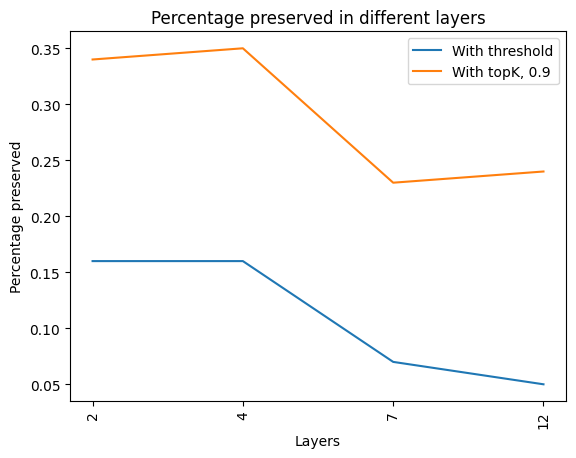

In [71]:
import matplotlib.pyplot as plt

layers = [2, 4, 7, 12]
avg_activation_threshold = [0.16, 0.16, 0.07, 0.05]
avg_activation_topk = [0.34, 0.35, 0.23, 0.24]

fig, ax = plt.subplots()
ax.plot([str(l) for l in layers], avg_activation_threshold, label="With threshold")
ax.plot([str(l) for l in layers], avg_activation_topk, label="With topK, 0.9")
ax.set_xlabel("Layers")
ax.set_ylabel("Percentage preserved")
ax.set_title("Percentage preserved in different layers")
#Set x axis to show ticks vertically
plt.xticks(rotation=90)
ax.legend()
plt.show()